# Setup #

In [177]:
#Importing Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import sklearn
import scipy
import scipy.stats as stats
from scipy.stats import skew,boxcox_normmax, zscore
from scipy.special import boxcox1p
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error 
from sklearn.model_selection import KFold, RandomizedSearchCV
from mlxtend.regressor import StackingCVRegressor
from multiprocessing import cpu_count
import xgboost as xgb
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

In [118]:
# importing
train_raw_data = pd.read_csv('train.csv')
test_raw_data = pd.read_csv('test.csv')

In [119]:
# copying
train_data = train_raw_data.copy()
test_data = test_raw_data.copy()

In [151]:
# view data
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [121]:
# view data
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Explore Data #

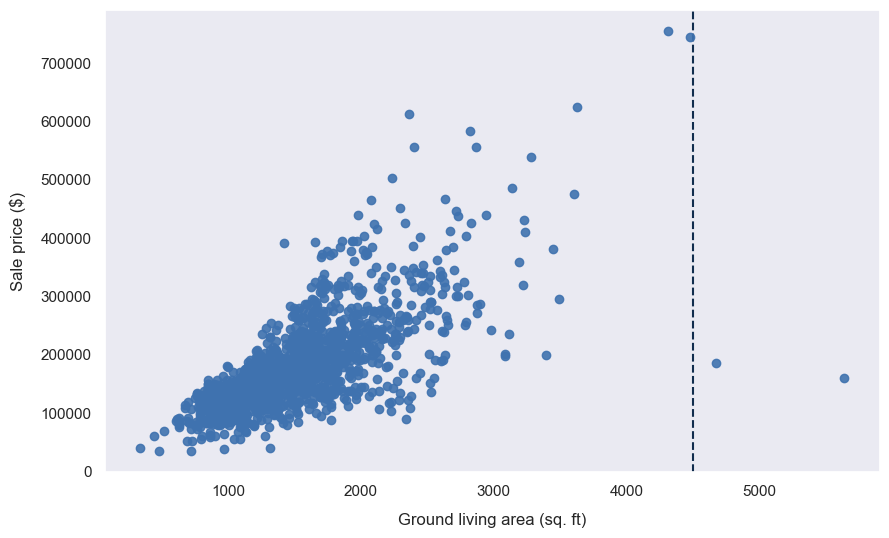

In [122]:
# scatter plot for outliers
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.scatter(train_data["GrLivArea"], train_data["SalePrice"], c="#3f72af", zorder=3, alpha=0.9)
ax.axvline(4500, c="#112d4e", ls="--", zorder=2)
ax.set_xlabel("Ground living area (sq. ft)", labelpad=10)
ax.set_ylabel("Sale price ($)", labelpad=10)
plt.show()

In [123]:
# Removing Outliers identified from above graph & merging train and test data
train_data = train_data[train_data["GrLivArea"]<4450]
data = pd.concat([train_data.drop("SalePrice", axis=1), test_data])

In [124]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2916 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2916 non-null   int64  
 1   MSSubClass     2916 non-null   int64  
 2   MSZoning       2912 non-null   object 
 3   LotFrontage    2430 non-null   float64
 4   LotArea        2916 non-null   int64  
 5   Street         2916 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2916 non-null   object 
 8   LandContour    2916 non-null   object 
 9   Utilities      2914 non-null   object 
 10  LotConfig      2916 non-null   object 
 11  LandSlope      2916 non-null   object 
 12  Neighborhood   2916 non-null   object 
 13  Condition1     2916 non-null   object 
 14  Condition2     2916 non-null   object 
 15  BldgType       2916 non-null   object 
 16  HouseStyle     2916 non-null   object 
 17  OverallQual    2916 non-null   int64  
 18  OverallC

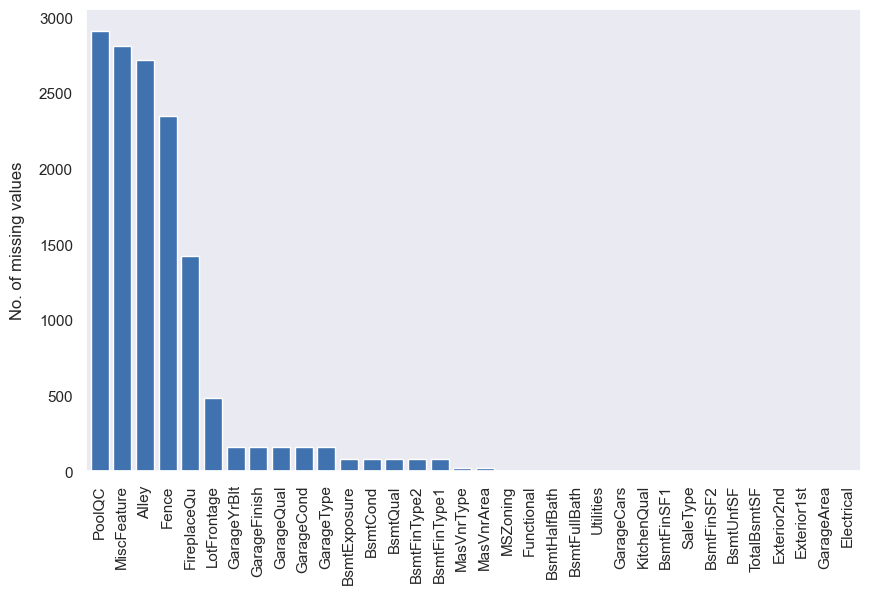

In [126]:
# bar graph to check for missing values

nans = data.isna().sum().sort_values(ascending=False)
nans = nans[nans > 0]
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.bar(nans.index, nans.values, zorder=2, color="#3f72af")
ax.set_ylabel("No. of missing values", labelpad=10)
ax.set_xlim(-0.6, len(nans) - 0.4)
ax.xaxis.set_tick_params(rotation=90)
plt.show()

In [127]:
# discrete vars

numerical_features=[]
for feature in train_data:
    if train_data[feature].dtype!='O' and feature!= 'SalePrice':
        numerical_features.append(feature)

discrete_variables=[]
for feature in numerical_features:
    if len(train_data[feature].unique())<=25 and feature != 'SalePrice':
        discrete_variables.append(feature)

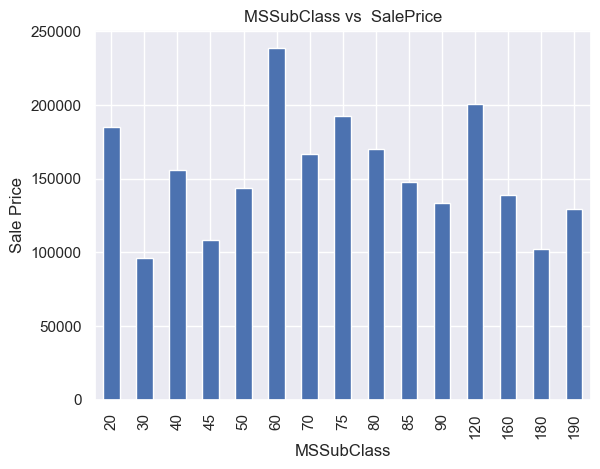

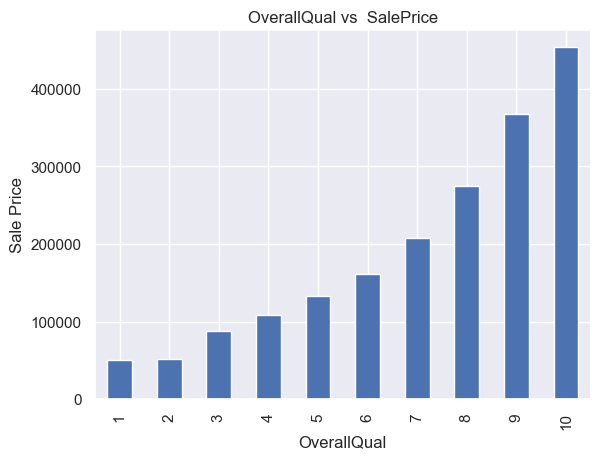

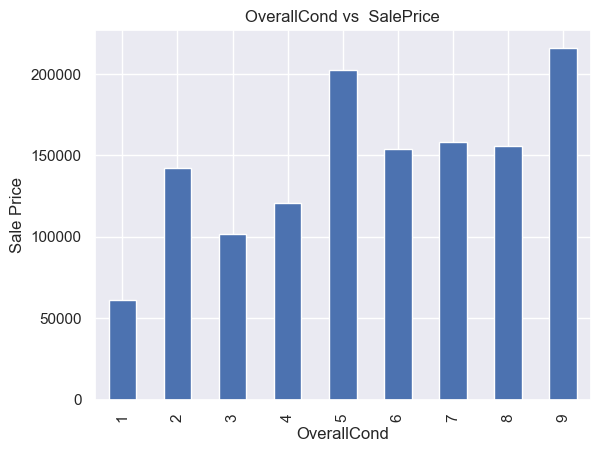

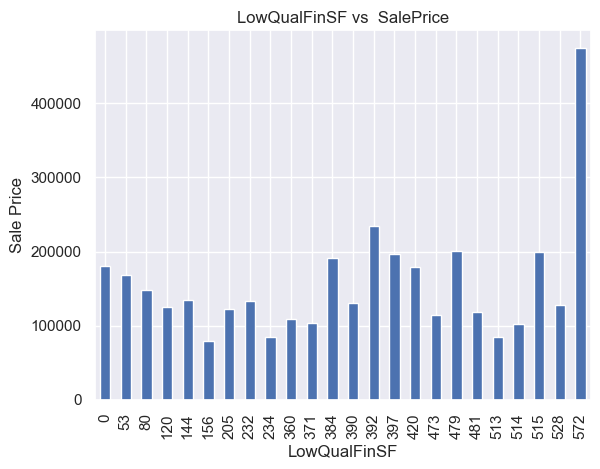

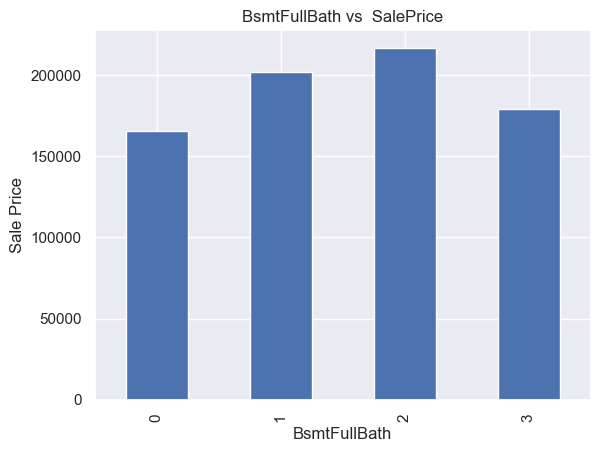

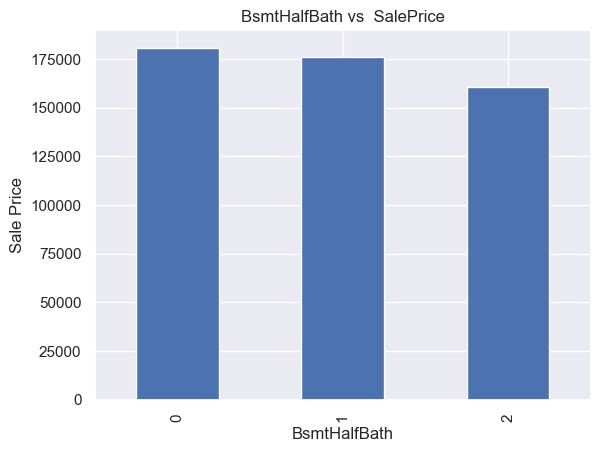

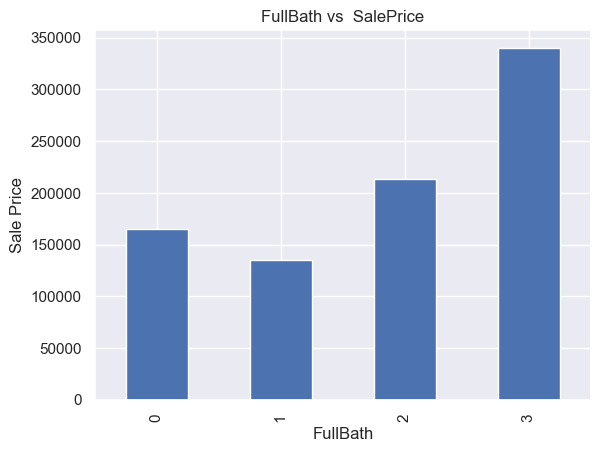

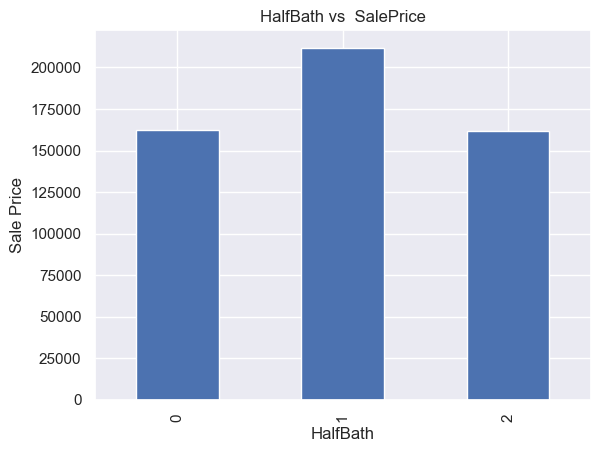

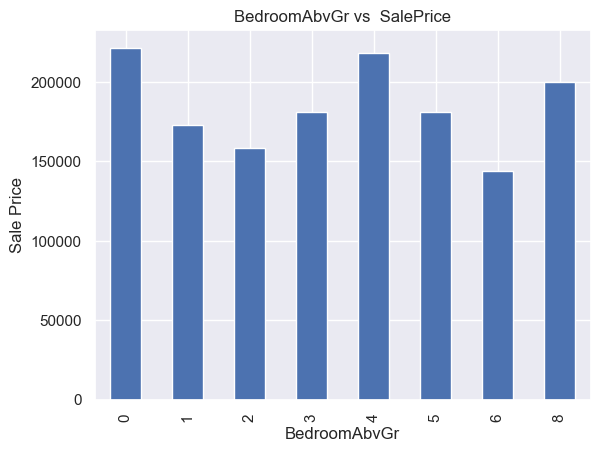

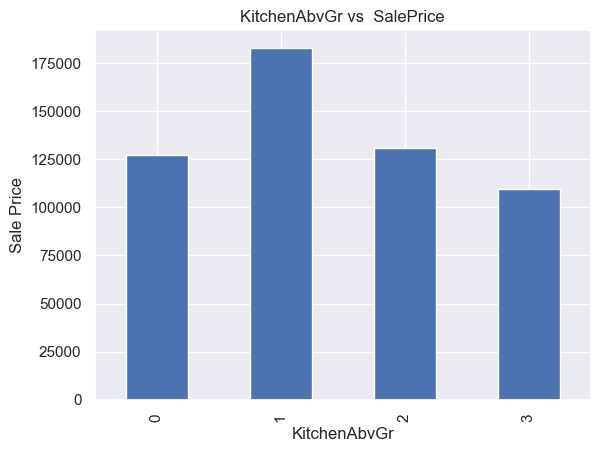

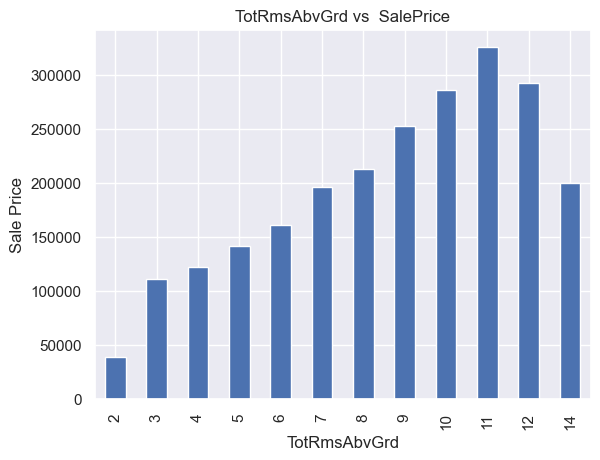

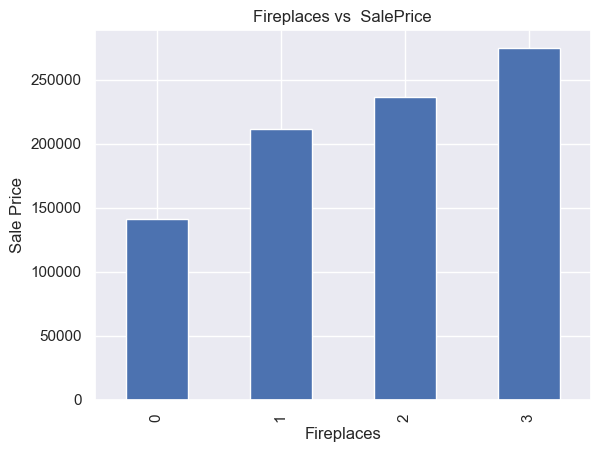

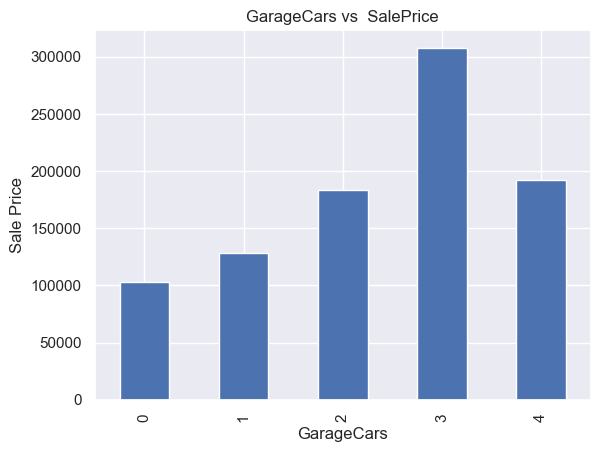

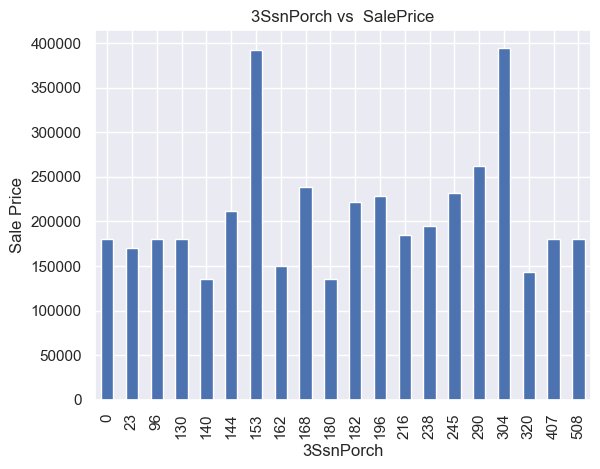

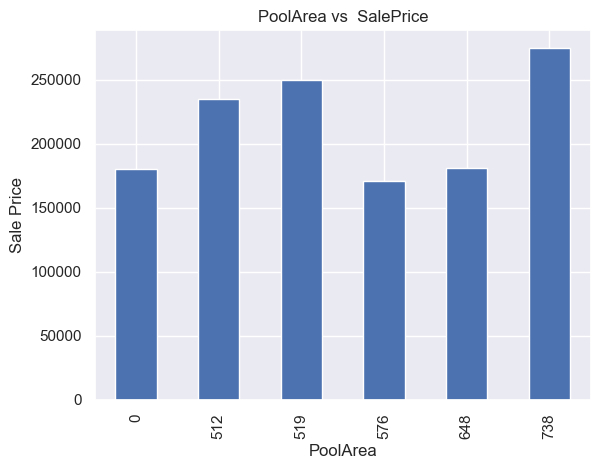

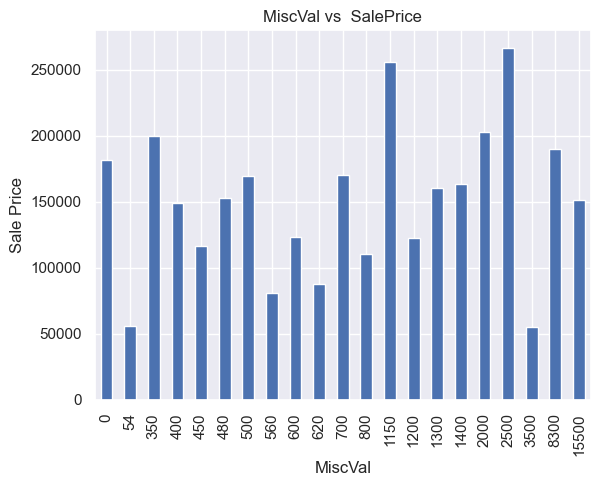

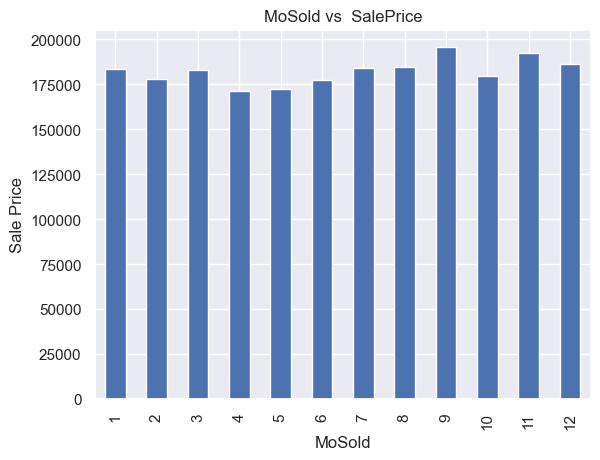

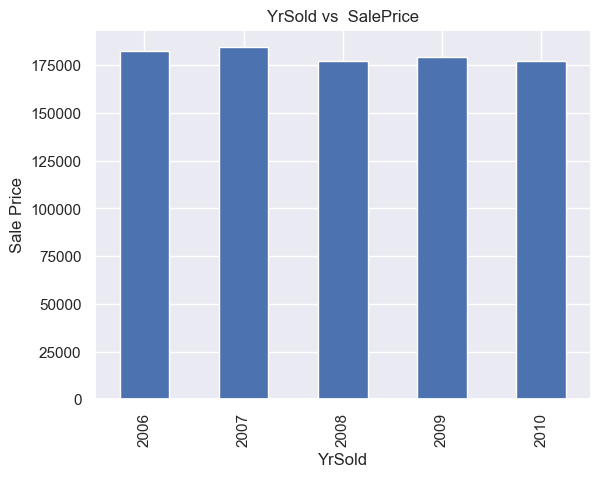

In [128]:
# plot discrete vars

for feature in discrete_variables:
     train_data.groupby(feature)['SalePrice'].mean().plot.bar()
     plt.xlabel(feature)
     plt.ylabel('Sale Price')
     plt.title(feature +' vs '+' SalePrice')
     plt.show()

In [129]:
# continuous variables

continuous_variables=[]
for feature in numerical_features:
    if feature not in discrete_variables and feature not in ["YearBuilt","YearRemodAdd","GarageYrBlt","YrSold"]:
        continuous_variables.append(feature)

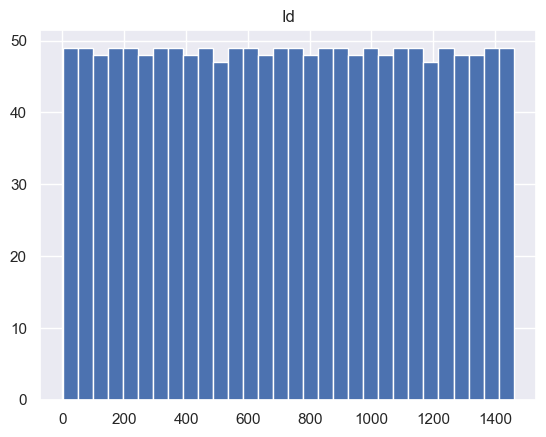

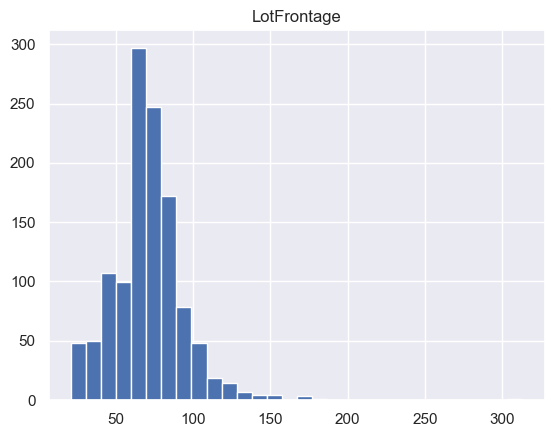

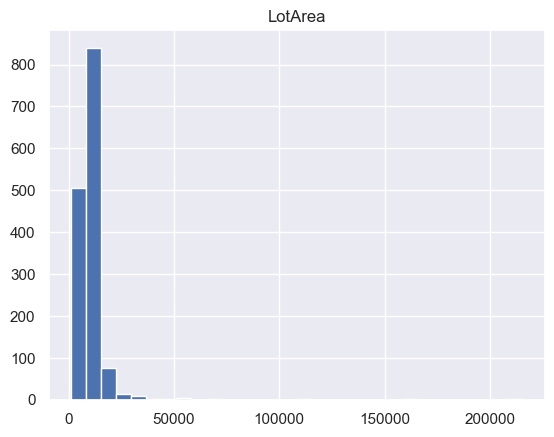

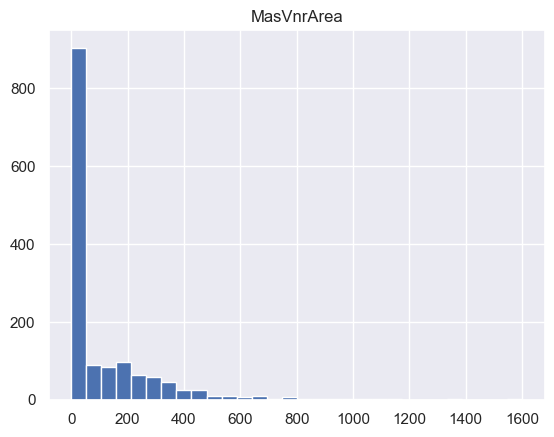

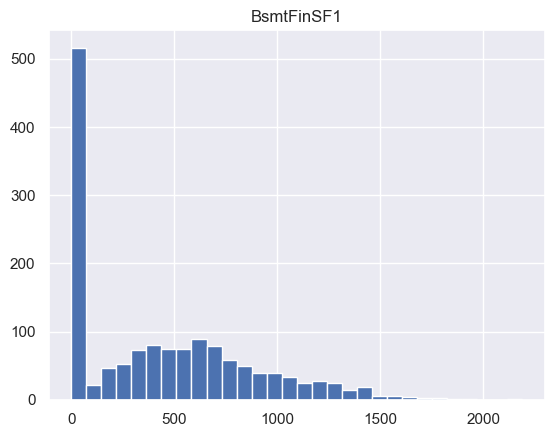

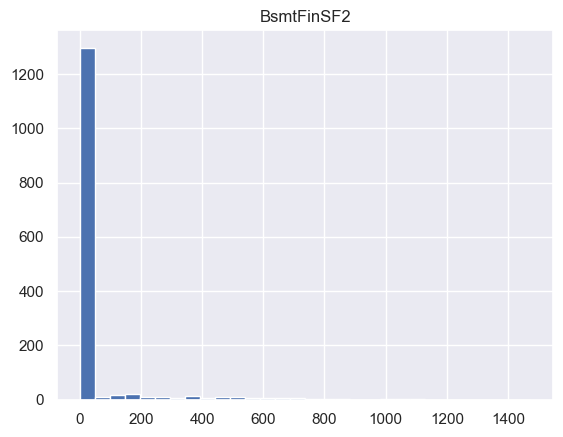

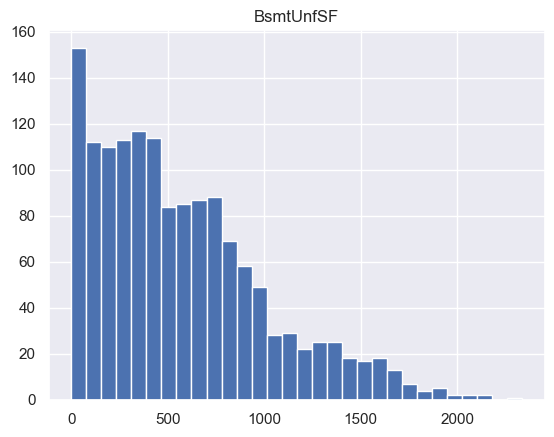

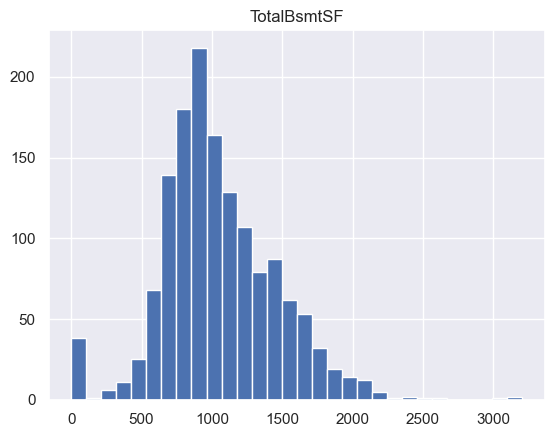

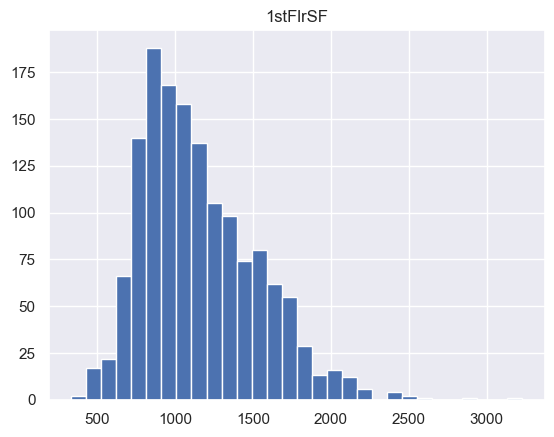

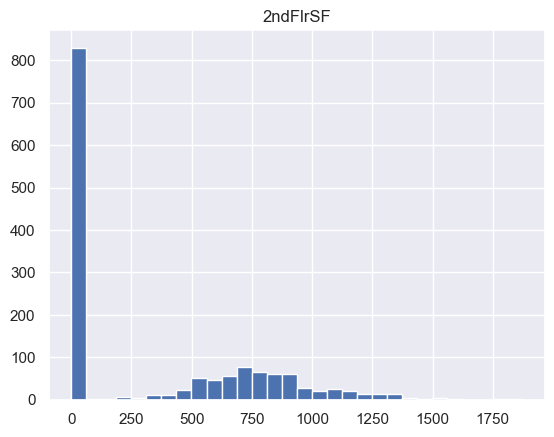

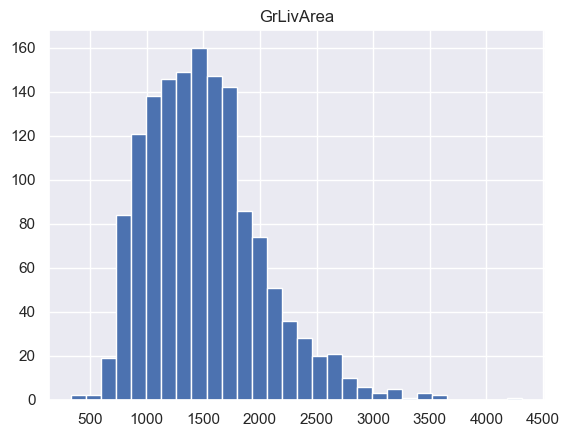

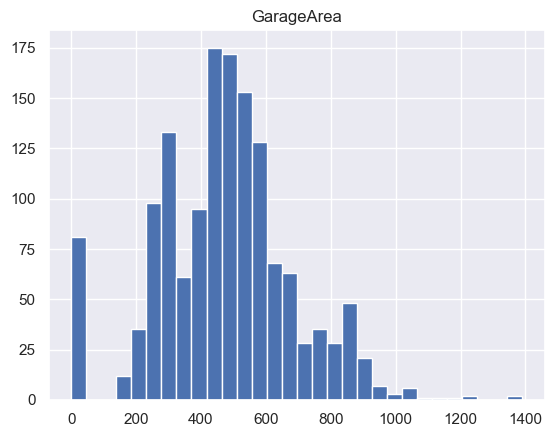

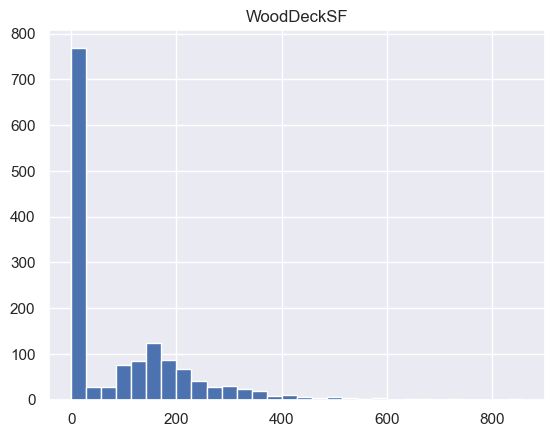

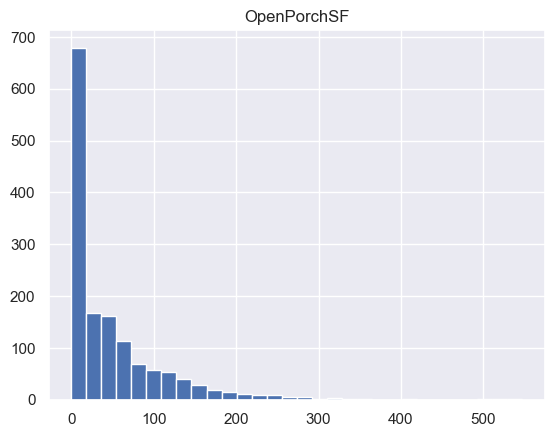

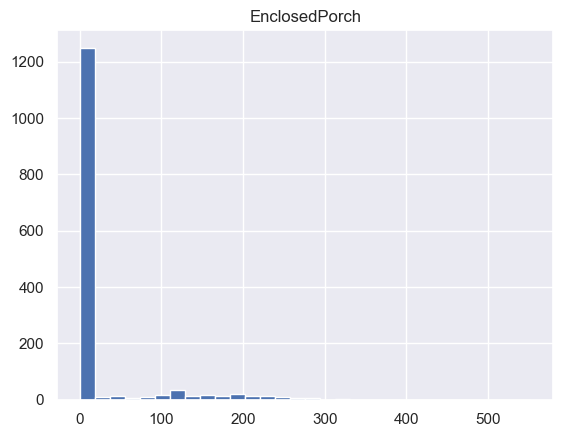

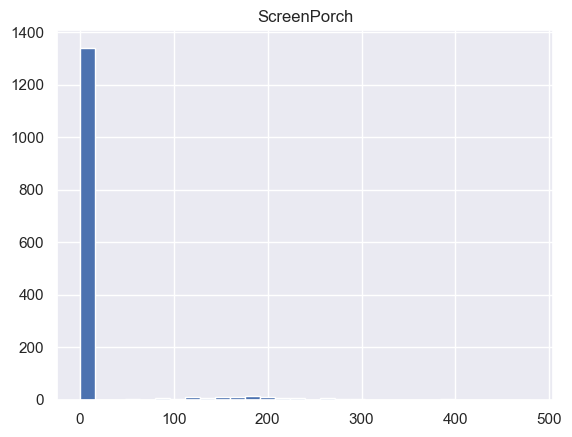

In [130]:
# plot continuous variables

for feature in continuous_variables:
     train_data[feature].hist(bins=30)
     plt.title(feature)
     plt.show()

In [131]:
# categorical variables

categorical_features=[]
for feature in train_data.columns:
    if train_data[feature].dtype=='O'and feature!= 'SalePrice':
        categorical_features.append(feature)

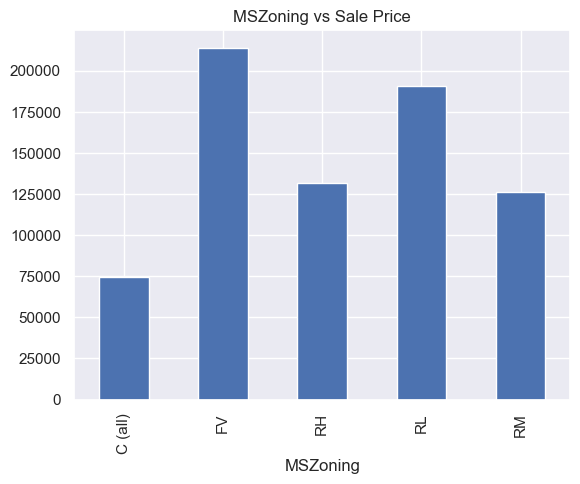

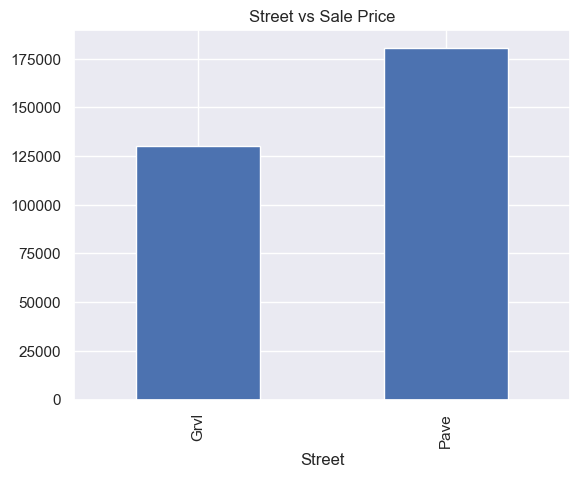

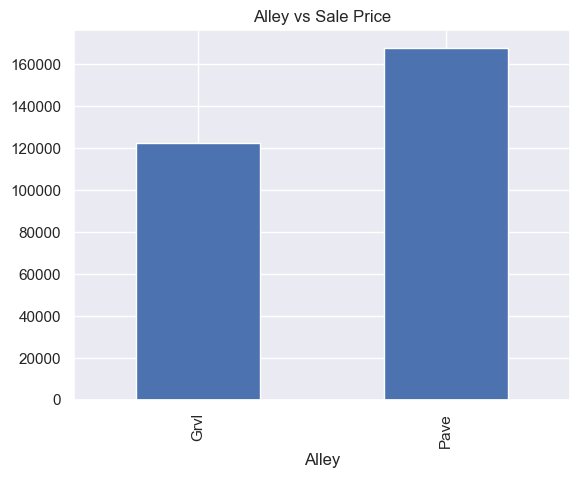

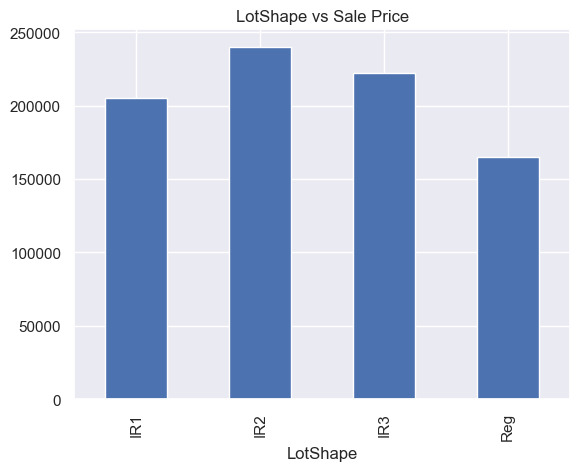

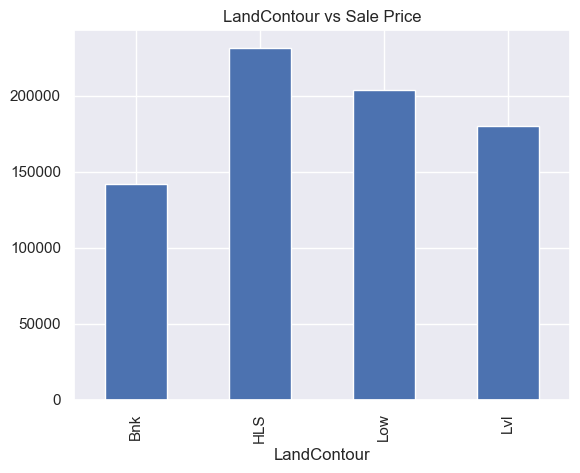

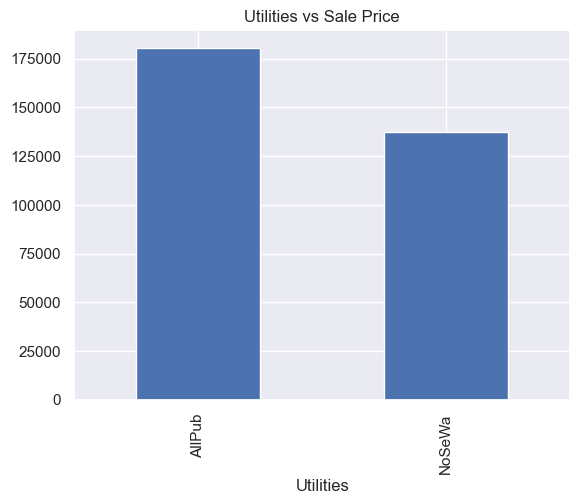

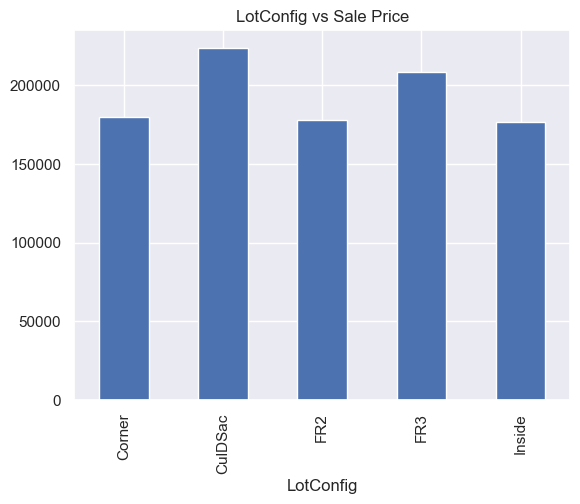

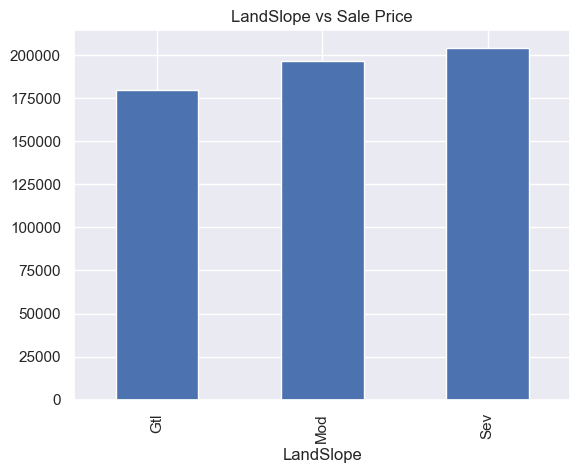

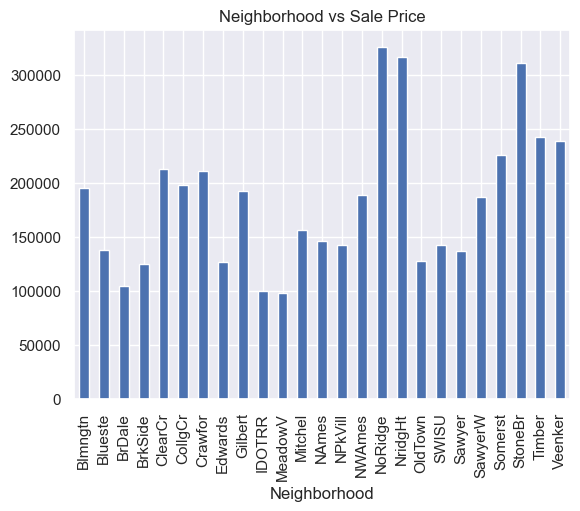

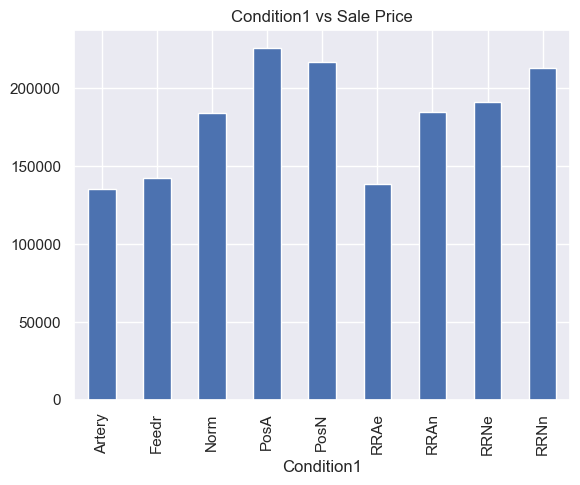

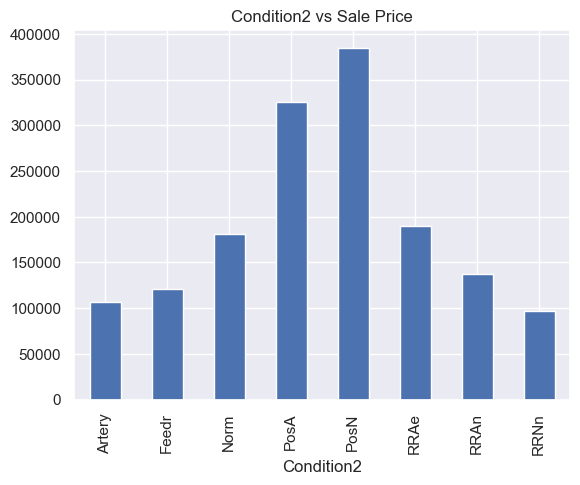

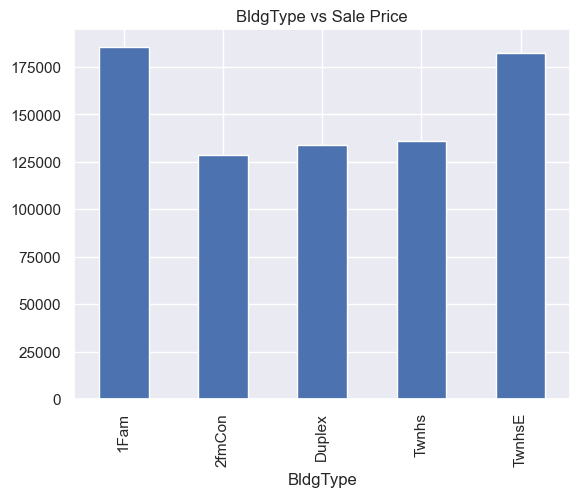

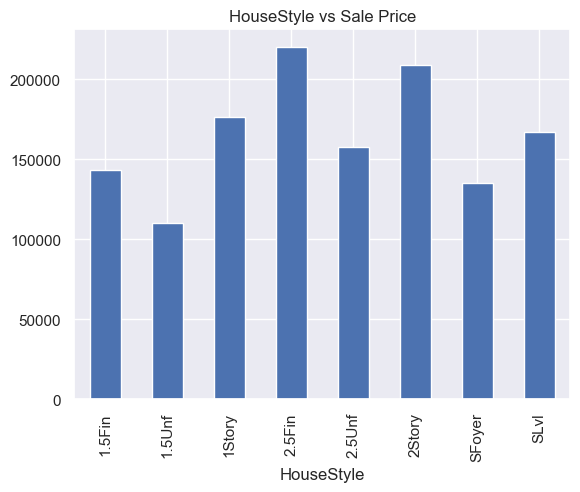

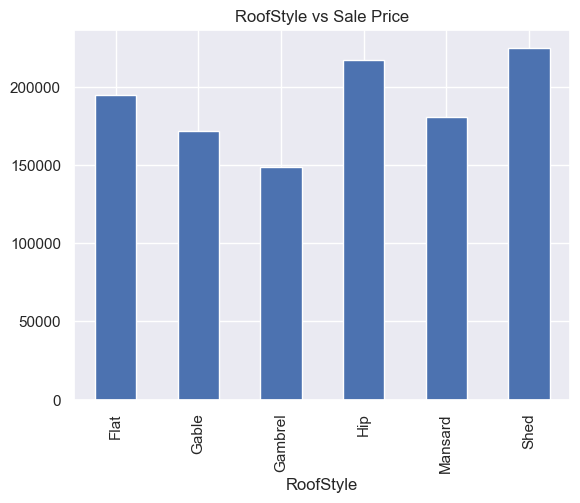

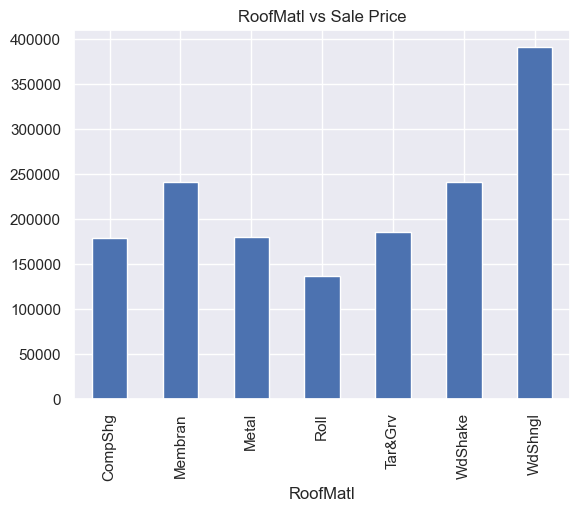

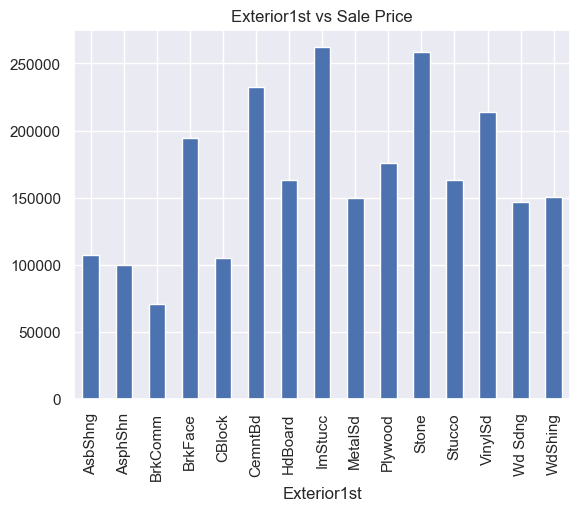

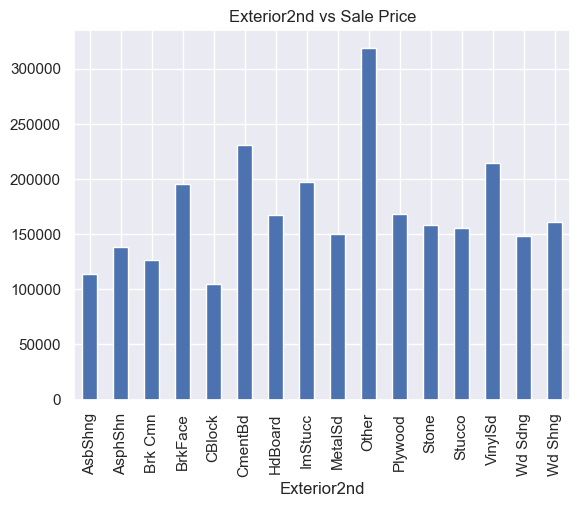

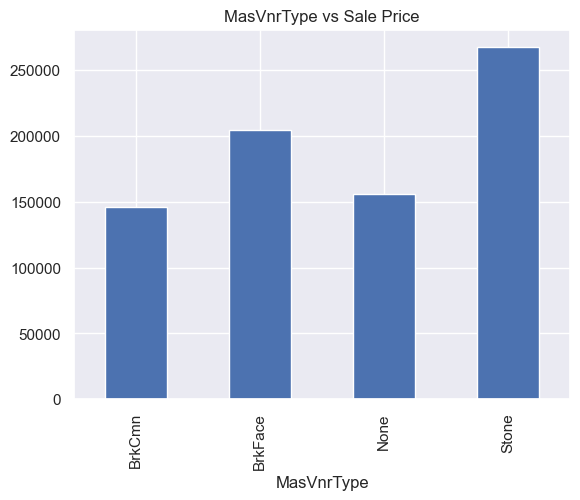

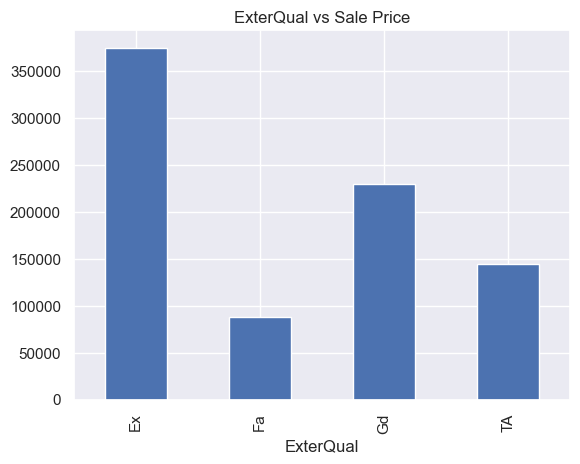

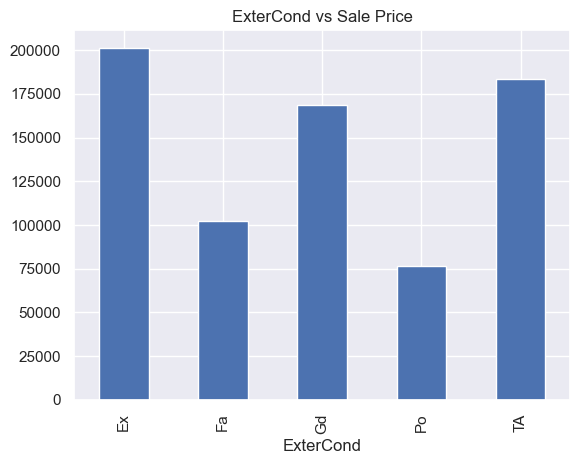

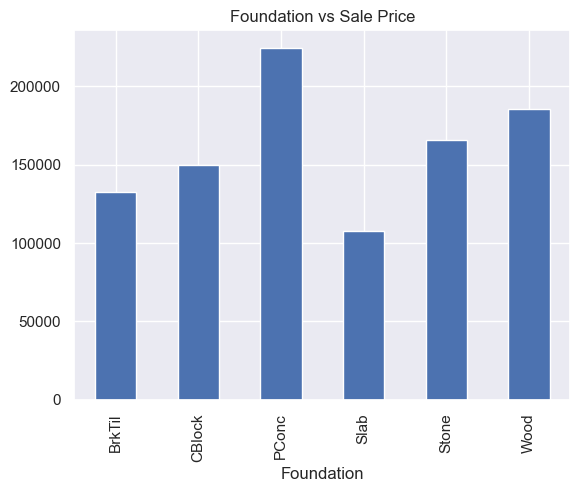

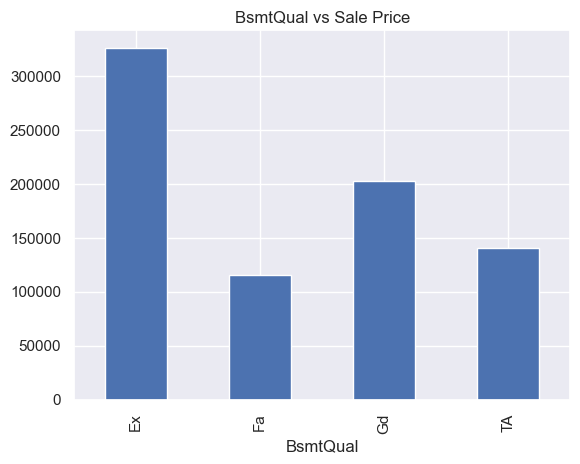

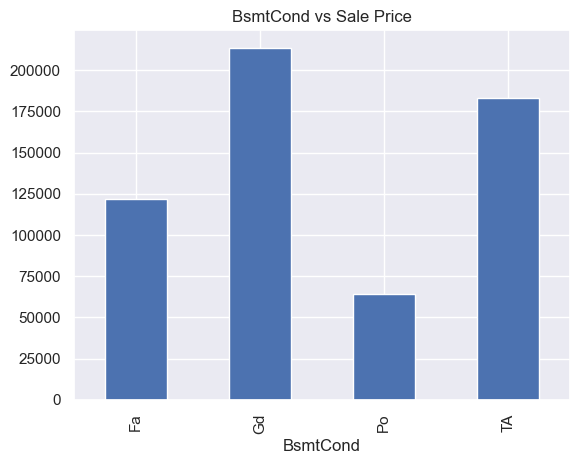

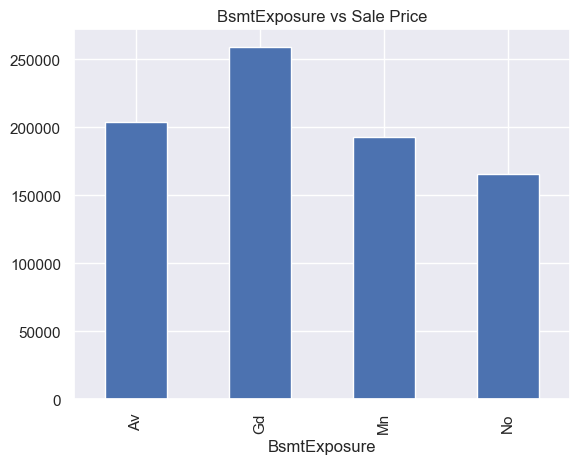

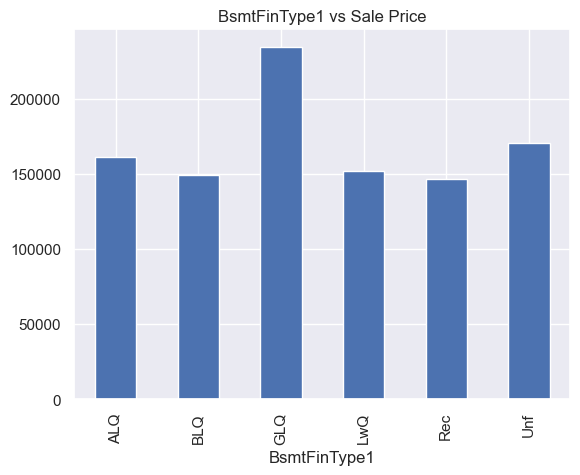

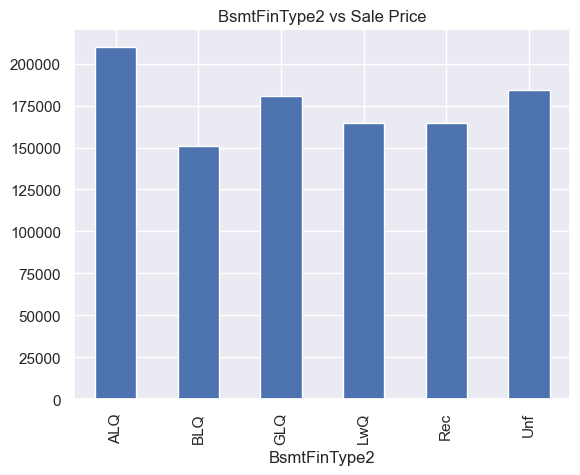

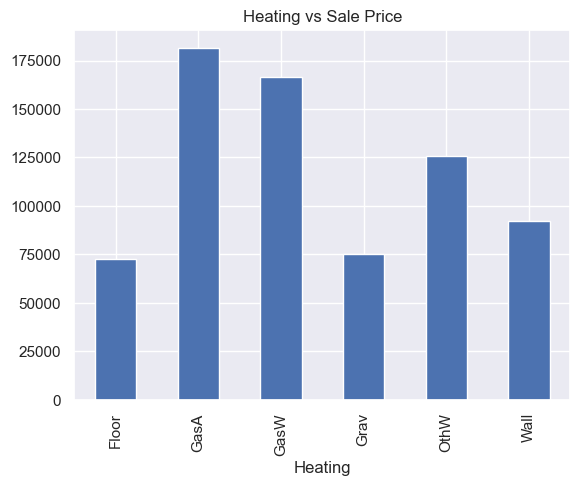

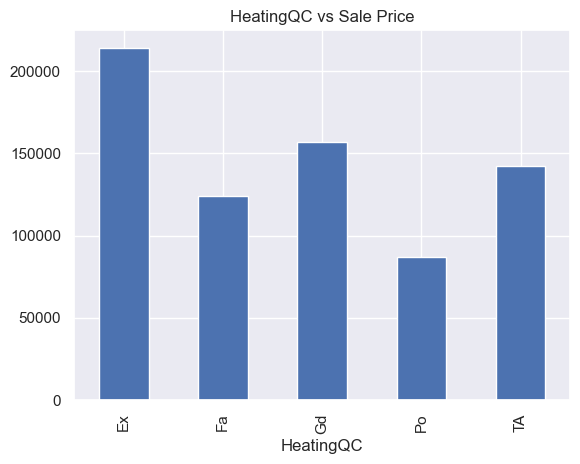

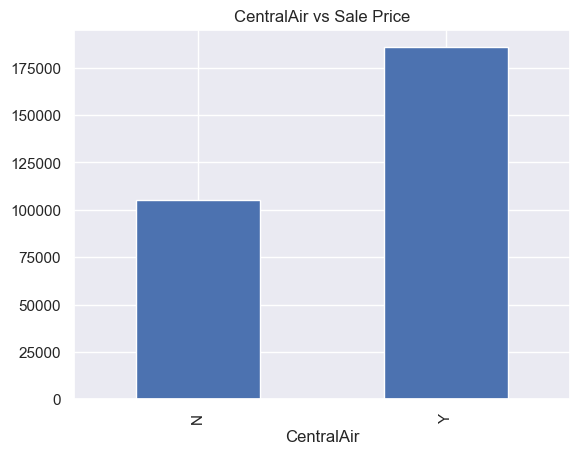

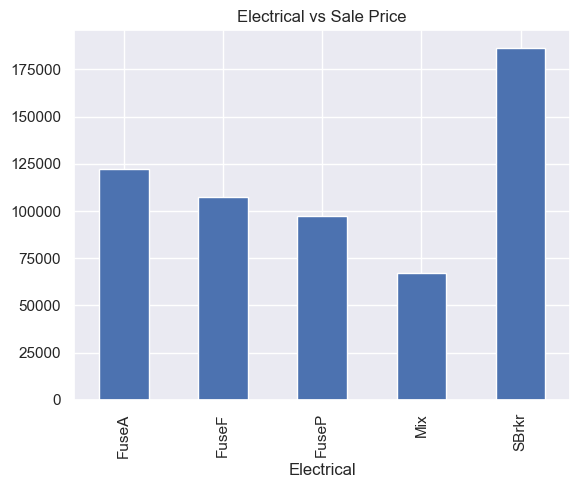

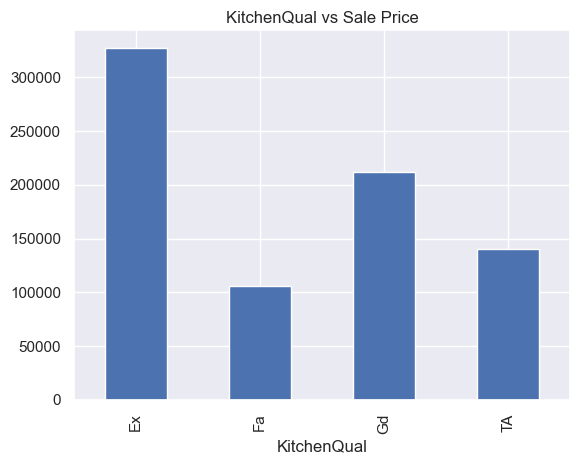

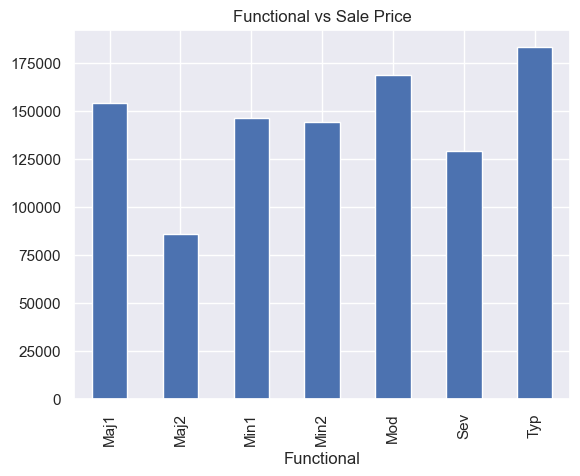

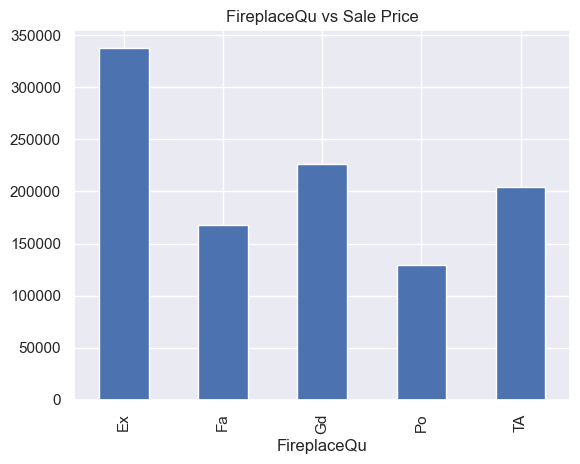

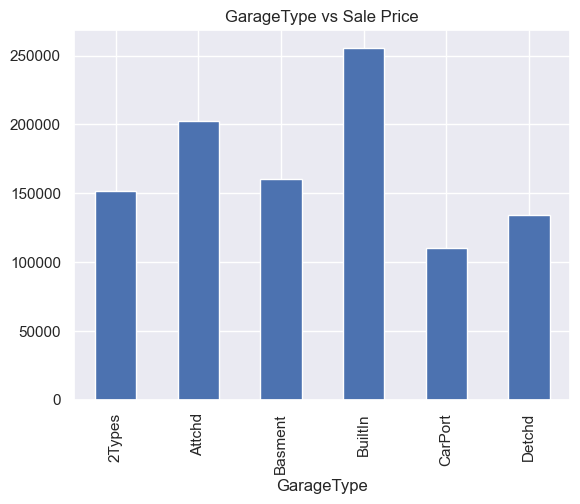

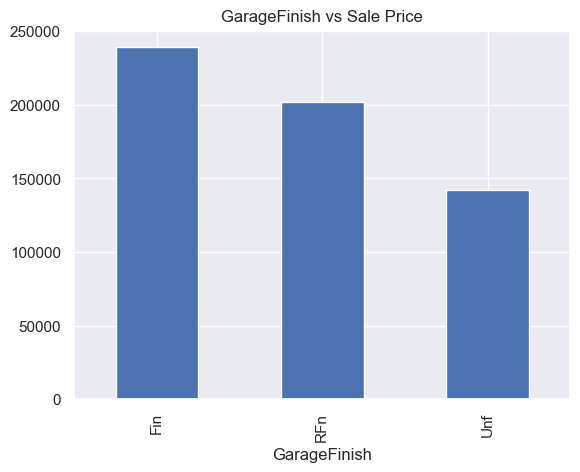

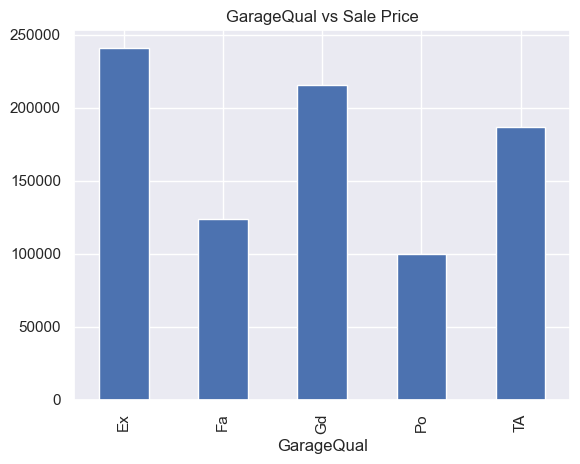

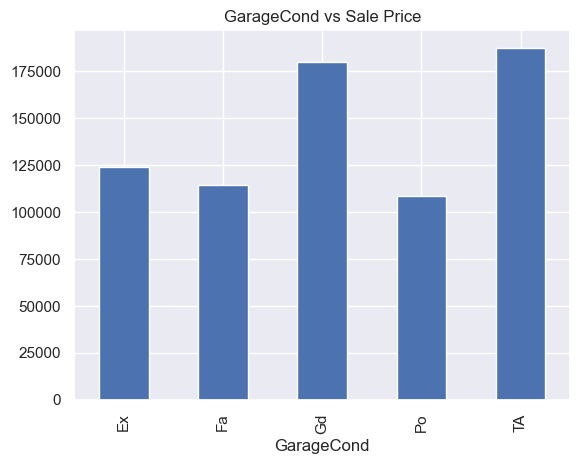

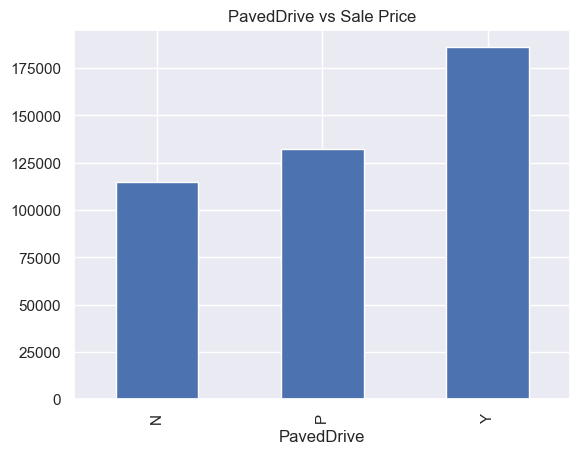

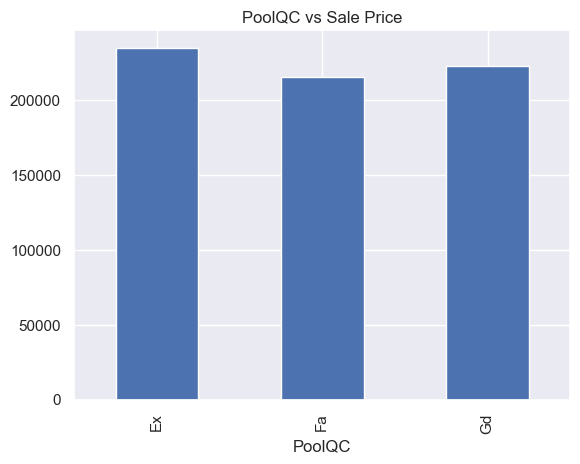

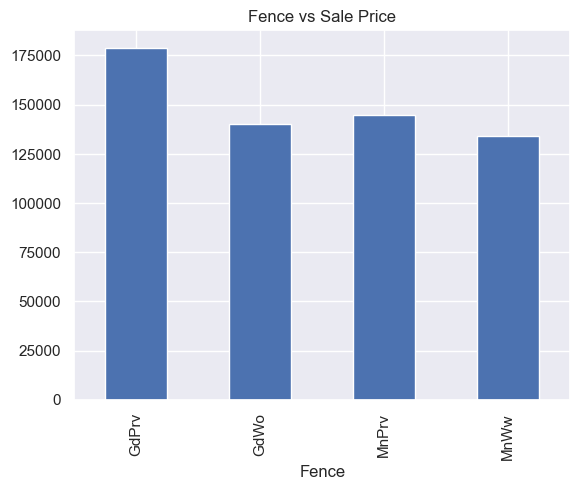

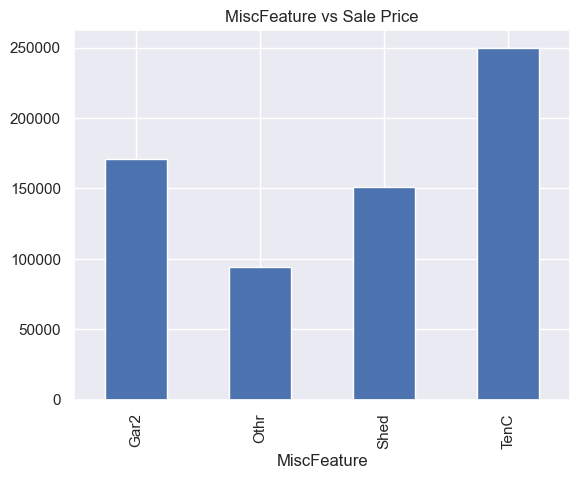

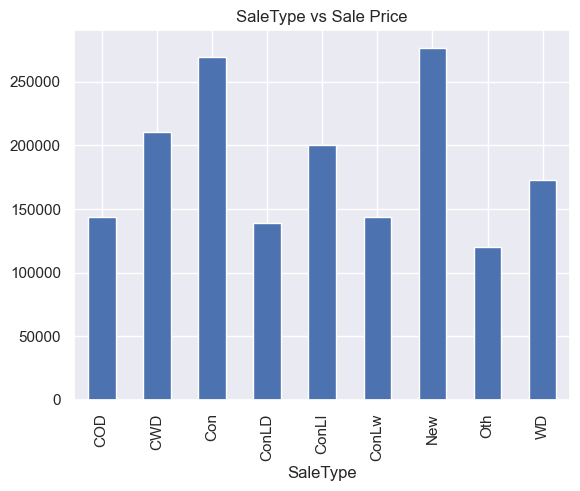

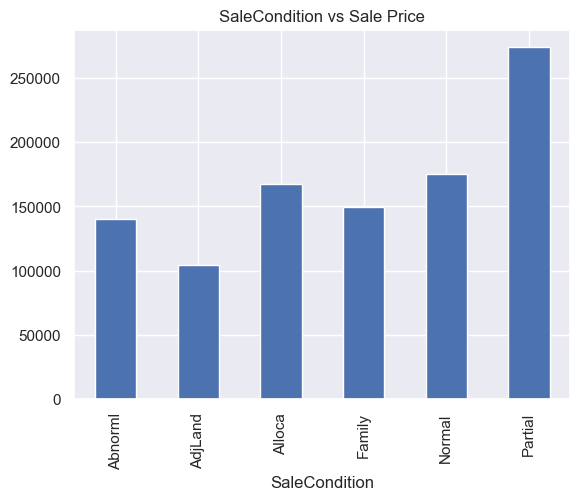

In [132]:
# plot categorical variables

for feature in categorical_features:
    train_data.groupby(feature)['SalePrice'].mean().plot.bar()
    plt.title(feature + ' vs Sale Price')
    plt.show()

/var/folders/60/0n715h651kj9q35r8z7tqtbm0000gn/T/ipykernel_60257/2786627025.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y1, kde=False, fit=stats.norm)
/var/folders/60/0n715h651kj9q35r8z7tqtbm0000gn/T/ipykernel_60257/2786627025.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y1, kde=F

<Axes: title={'center': 'Log Normal'}, xlabel='SalePrice'>

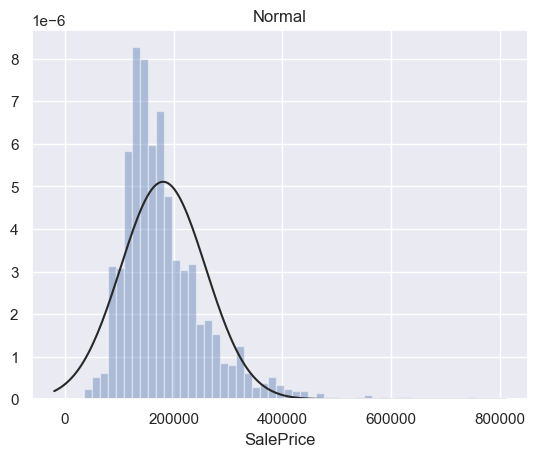

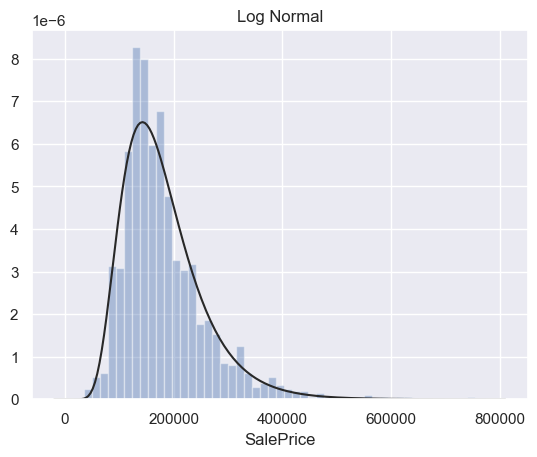

In [133]:
# Plotting the Distribution of the target variable


y1 = train_data['SalePrice']
plt.figure(2); plt.title('Normal')
sns.distplot(y1, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y1, kde=False, fit=stats.lognorm)

In [148]:
# log transform target, given not normal distribution

y = np.log(train_data["SalePrice"])

/var/folders/60/0n715h651kj9q35r8z7tqtbm0000gn/T/ipykernel_60257/991049277.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_train = train_data.corr()


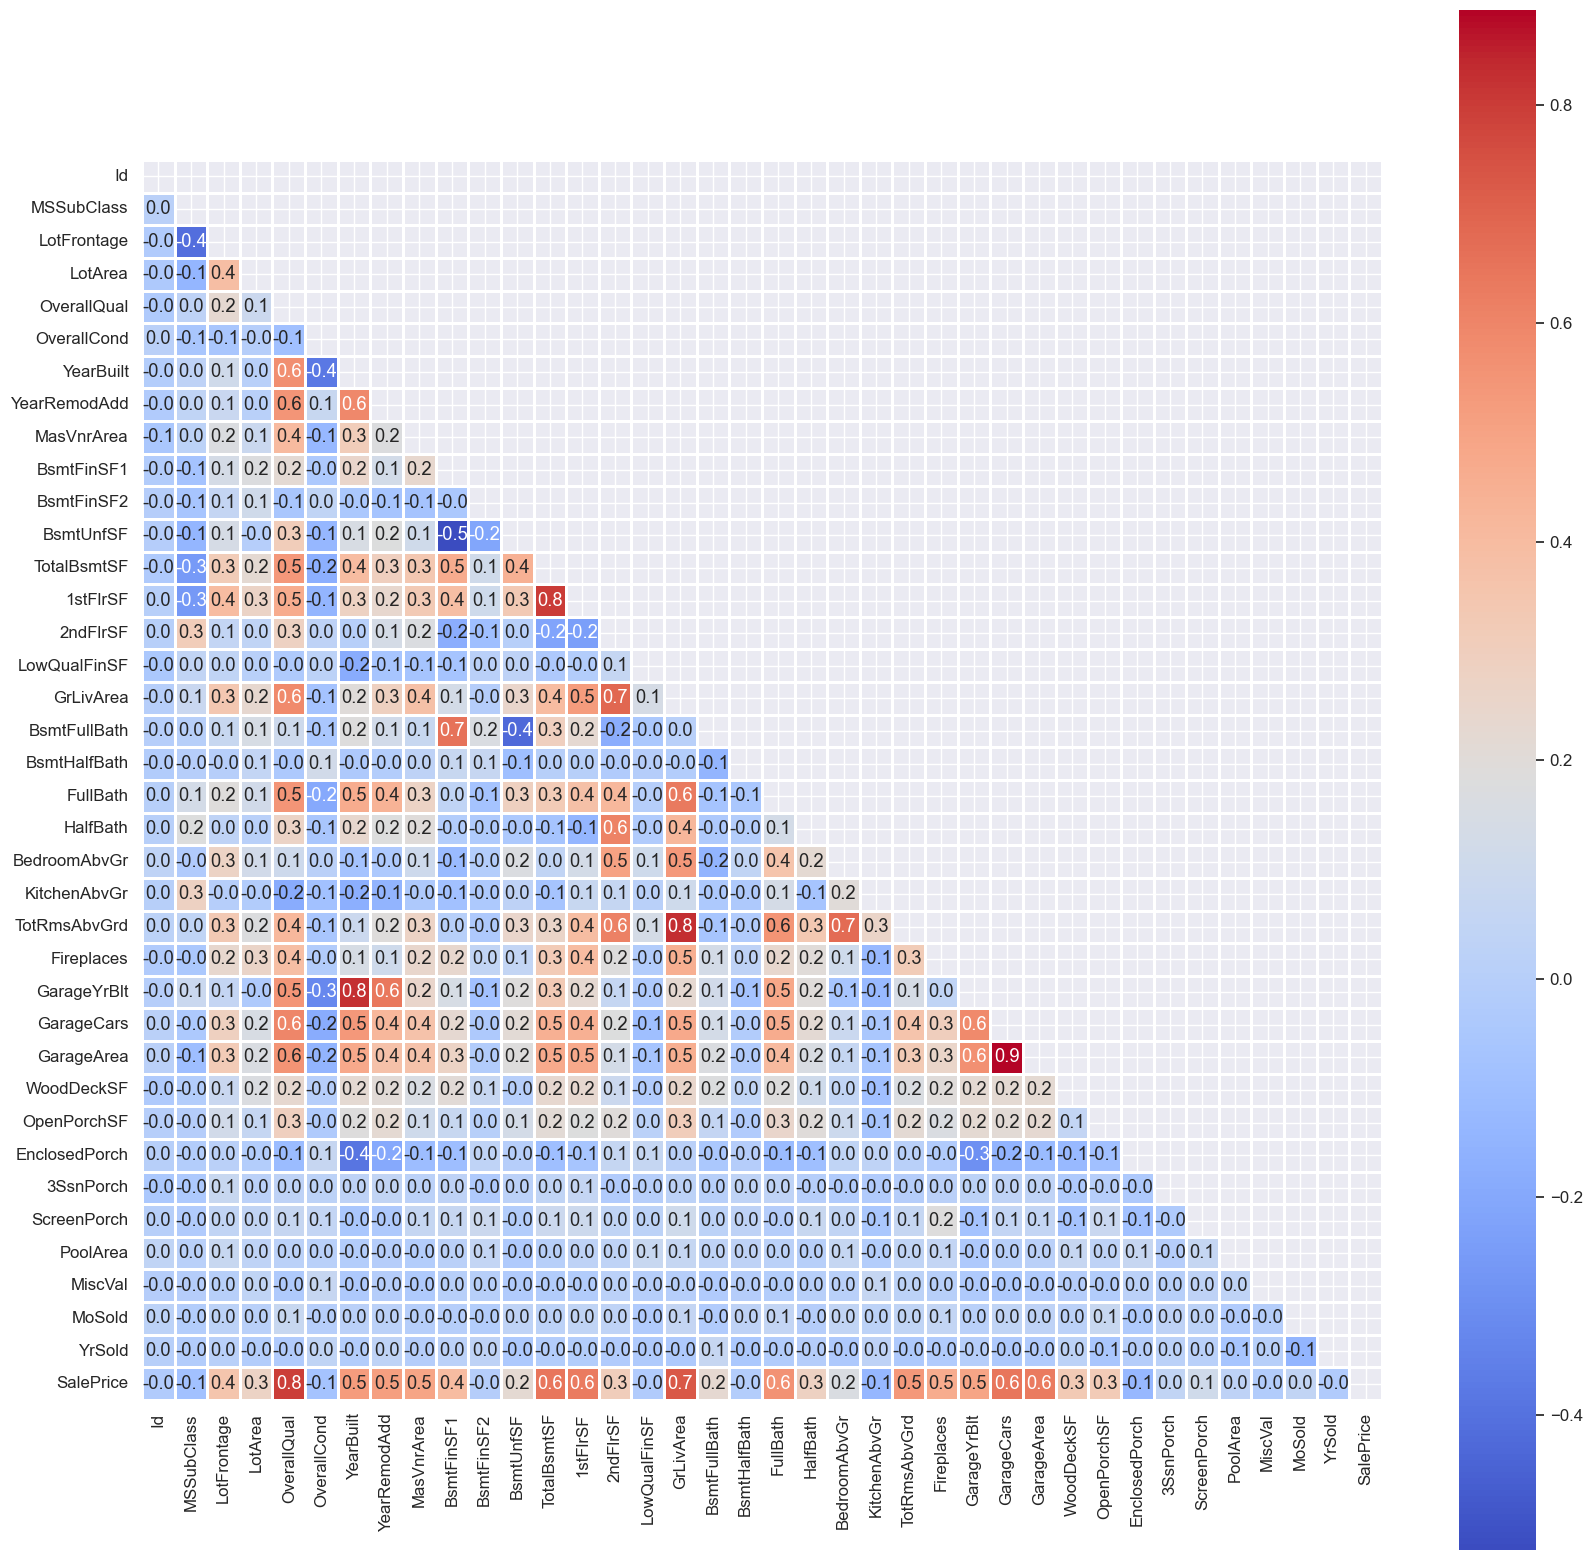

In [135]:
# correlation heatmaps

sns.set(font_scale=1.1)
corr_train = train_data.corr()
mask = np.triu(corr_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(corr_train, annot=True, fmt='.1f', cmap='coolwarm', square=True, mask=mask, linewidth=1, cbar=True)
plt.show()

# Data Imputation #

In [136]:
features_nonefill = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageCond", "GarageQual", "GarageFinish", "GarageType", "BsmtCond", "BsmtExposure", "BsmtQual", "BsmtFinType2", "BsmtFinType1"]
data[features_nonefill] = data[features_nonefill].fillna("None")

In [137]:
features_modefill = ["MasVnrType", "MSZoning", "Utilities", "Exterior1st", "Exterior2nd", "SaleType", "Electrical", "KitchenQual", "Functional"]
data[features_modefill] = data.groupby("Neighborhood")[features_modefill].transform(lambda x:x.fillna(x.mode()[0])) #grouping by Neighborhood

In [138]:
features_medianfill = ["GarageArea", "LotFrontage"]
data[features_medianfill] = data.groupby("Neighborhood")[features_medianfill].transform(lambda x: x.fillna(x.median())) #grouping by Neighborhood

In [139]:
features_zerofill = ["GarageYrBlt", "MasVnrArea", "BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "GarageCars"]
data[features_zerofill] = data[features_zerofill].fillna(0)

# Feature Engineering #

In [140]:
# create new meaningful columns

# areas
data["TotalArea"] = data["GrLivArea"] + data["TotalBsmtSF"]
data["TotalBaths"] = data["FullBath"] + data["BsmtFullBath"] + 0.5*(data["HalfBath"]+data["BsmtHalfBath"])
data["TotalPorch"] = data["OpenPorchSF"] + data["EnclosedPorch"] + data["3SsnPorch"] + data["ScreenPorch"]

# logical features
data['Pool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
data['2ndFloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
data['Garage'] = data['GarageCars'].apply(lambda x: 1 if x > 0 else 0)
data['Bsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
data['Fireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
data['Porch'] = data['TotalPorch'].apply(lambda x: 1 if x > 0 else 0)

# Data Transform & Feature Scaling #

In [141]:
# convert to categorical var

data[["MSSubClass", "YrSold"]] = data[["MSSubClass", "YrSold"]].astype("category")

In [142]:
# convert to cyclic value

data["MoSoldsin"] = np.sin(2 * np.pi * data["MoSold"] / 12) #Sine Function
data["MoSoldcos"] = np.cos(2 * np.pi * data["MoSold"] / 12) #Cosine Function
data = data.drop("MoSold", axis=1)

In [143]:
# normalize data with high skew using box-cox

skewed = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'LowQualFinSF', 'MiscVal'
]
skew_features = np.abs(data[skewed].apply(lambda x: skew(x)).sort_values(
    ascending=False))

# Filtering skewed features.

high_skew = skew_features[skew_features > 0.3]

# Taking indexes of high skew.

skew_index = high_skew.index

# Applying boxcox transformation to fix skewness.

for i in skew_index:
    data[i] = boxcox1p(data[i], boxcox_normmax(data[i] + 1)) #Normalizing Skewed Data

/Users/helennie/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/helennie/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4461: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


In [144]:
# feature scaling

cols = data.select_dtypes(np.number).columns
data[cols] = RobustScaler().fit_transform(data[cols])

In [145]:
# encoding

data = pd.get_dummies(data)

In [167]:
# feature Recovery

X_train = data.iloc[train_data.index]
X_test = data.iloc[test_data.index]

In [170]:
# remove Outliers

residuals = y - LinearRegression().fit(X_train, y).predict(X_train)
outliers = residuals[np.abs(zscore(residuals)) > 3].index

X_train = X_train.drop(outliers)
y = y.drop(outliers)

# Optimization, Training, and Testing #

In [171]:
# Hyper param optimization

kf = KFold(n_splits=5, random_state=0, shuffle=True)
rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))
scorer = make_scorer(rmse, greater_is_better=False)

In [174]:
def random_search(model, grid, n_iter=100):
    if model == xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4):
        searchxg = RandomizedSearchCV(estimator = model, param_distributions = grid, cv=kf, n_iter = n_iter, n_jobs=4, random_state=0, verbose=True)
        return searchxg.fit(X_train,y,early_stopping_rounds=5,verbose=True)
    else:
        search = RandomizedSearchCV(estimator = model, param_distributions = grid, cv=kf, n_iter = n_iter, n_jobs=4, random_state=0, verbose=True)
        return search.fit(X_train, y)

In [175]:
#hyperparameter Grids
xgb_hpg = {'n_estimators': [100, 400, 800],'max_depth': [3, 6, 9],'learning_rate': [0.05, 0.1, 0.20],'min_child_weight': [1, 10, 100]} #XGBoost
ridge_hpg = {"alpha": np.logspace(-1, 2, 500)} #Ridge Regressor
lasso_hpg = {"alpha": np.logspace(-5, -1, 500)} #Lasso Regressor
svr_hpg = {"C": np.arange(1, 100), "gamma": np.linspace(0.00001, 0.001, 50), "epsilon": np.linspace(0.01, 0.1, 50)} #Support Vector Regressor
lgbm_hpg = {"colsample_bytree": np.linspace(0.2, 0.7, 6), "learning_rate": np.logspace(-3, -1, 100)} #LGBM 
gbm_hpg = {"max_features": np.linspace(0.2, 0.7, 6), "learning_rate": np.logspace(-3, -1, 100)} #Gradient Boost
cat_hpg = {'depth': [2,9], 'iterations': [10,30] ,'learning_rate': [0.001,0.1]}

In [178]:
xgb_search = random_search(xgb.XGBRegressor(n_estimators=1000, n_jobs=4),xgb_hpg) #XGBoost
ridge_search = random_search(Ridge(), ridge_hpg) #Ridge Regressor
lasso_search = random_search(Lasso(), lasso_hpg) #Lasso Regressor
svr_search = random_search(SVR(), svr_hpg,n_iter=100) #Support Vector Regressor
lgbm_search = random_search(LGBMRegressor(n_estimators=2000, max_depth=3), lgbm_hpg,n_iter=100) #LGBM
gbm_search = random_search(GradientBoostingRegressor(n_estimators=2000, max_depth=3),gbm_hpg,n_iter=100) #Gradient Boost


Fitting 5 folds for each of 81 candidates, totalling 405 fits


/Users/helennie/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# ensemble learning more

models = [search.best_estimator_ for search in [xgb_search,ridge_search, lasso_search, svr_search, lgbm_search, gbm_search]] #list of best estimators from each model
ensemble_search = random_search(StackingCVRegressor(models,Ridge(), cv=kf), {"meta_regressor__alpha": np.logspace(-3, -2, 500)}, n_iter=20) #Ensemble Stack
models.append(ensemble_search.best_estimator_) #list of best estimators from each model including Stack

In [ ]:
# predicting

prediction = [i.predict(X_test) for i in models] #Np array of Predictions
p = prediction